In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
import gc
import sys
import os
sys.path.append(os.path.abspath("../../.."))

from utils.scatter_plot import scatter_prediction
from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model

Training XGBoost model...
XGBoost Performance Metrics:
MAE: 4237.58
MSE: 713073664.00
RMSE: 26703.44
R²: 0.66
------------------------------


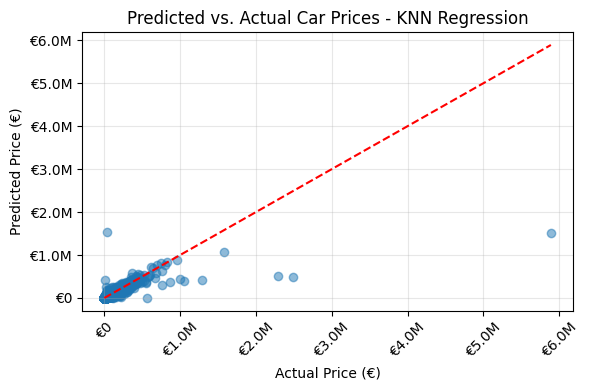

In [2]:

# 1) Daten laden / splitten
X_train, X_test, y_train, y_test, cat_feats, num_feats = split_data('../../../data.csv')

# 2) Transformer
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# 3) XGBoost-Pipeline
xgb_pipeline = Pipeline([
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training XGBoost model...")

xgb_pipeline.fit(X_train, y_train)

y_pred = xgb_pipeline.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")
scatter_prediction(y_test, y_pred, "KNN Regression")


<Figure size 1500x1000 with 0 Axes>

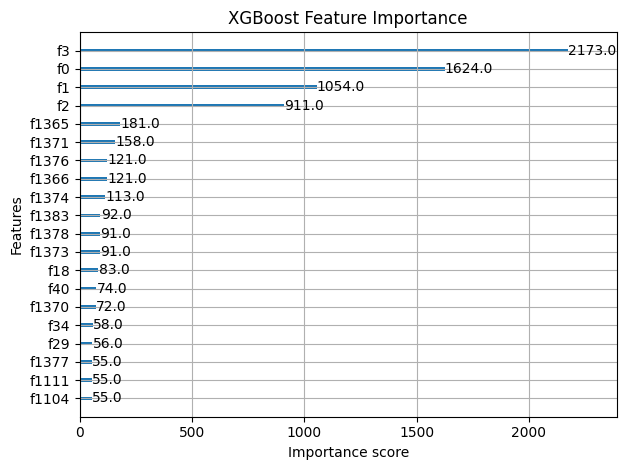

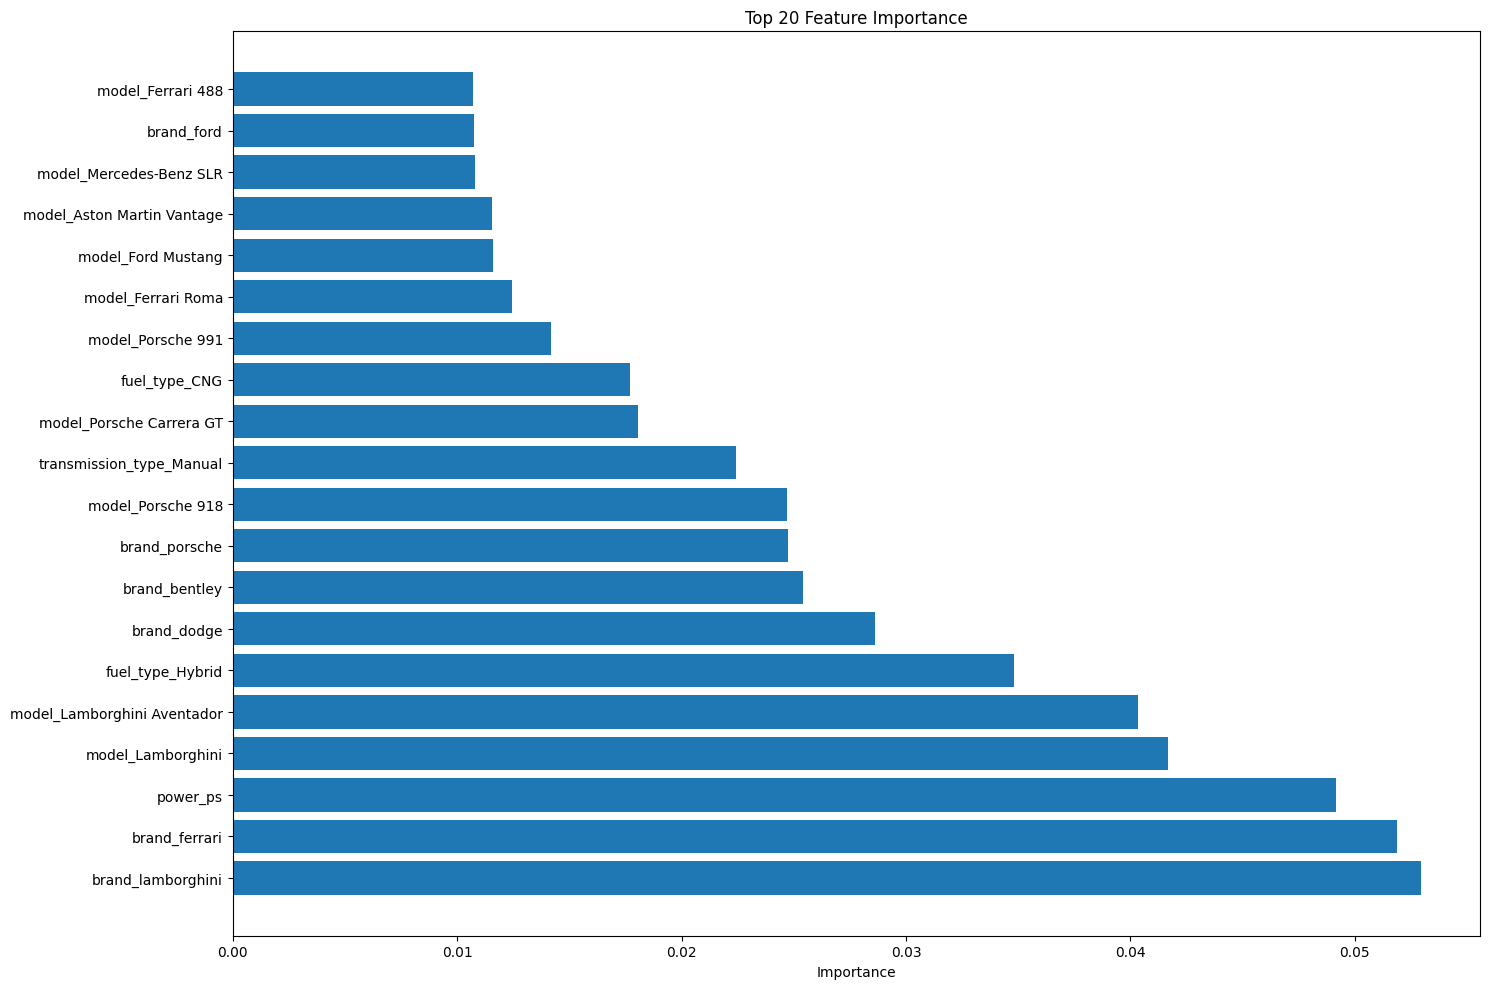

In [22]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Extract the XGBoost model from the pipeline
xgb_model = xgb_pipeline.named_steps['model']

# Get feature names from preprocessor
preprocessor = xgb_pipeline.named_steps['preprocessor']
feature_names = []

# Get numeric feature names
numeric_features = num_feats

# Get one-hot encoded categorical feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_features = ohe.get_feature_names_out(input_features=cat_feats)

# Combine all feature names
all_features = list(numeric_features) + list(categorical_features)

# Plot feature importance with a good figure size
plt.figure(figsize=(15, 10))
plot_importance(xgb_model, max_num_features=20, title='XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Additional plot showing importance with feature names
importances = xgb_model.feature_importances_

# Create an array of feature importances with their names
feature_importance = []
for i, importance in enumerate(importances):
    if i < len(all_features):
        feature_importance.append((all_features[i], importance))

# Sort by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Plot custom feature importance
plt.figure(figsize=(15, 10))
features = [x[0] for x in feature_importance[:20]]
importance_values = [x[1] for x in feature_importance[:20]]

plt.barh(range(len(features)), importance_values, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()